In [1]:
import xarray as xr
from sea_breeze import sea_breeze_filters, load_model_data, sea_breeze_funcs, utils
from dask.distributed import Client
import os
import pandas as pd
from dask.distributed import Client, progress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import skimage
import warnings

from sea_breeze.sea_breeze_filters import *

In [2]:
client = Client()

2025-03-13 13:53:02,590 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-03-13 13:53:02,593 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-03-13 13:53:02,599 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46775 instead
  warnings.warn(


Modifying workers


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0037.gadi.nci.org.au/10961/proxy/38569/status,
Dashboard: /node/gadi-cpu-bdw-0037.gadi.nci.org.au/10961/proxy/38569/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42493,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0037.gadi.nci.org.au/10961/proxy/38569/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44829,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0037.gadi.nci.org.au/10961/proxy/36843/status,Memory: 0 B
Nanny: tcp://127.0.0.1:41969,


In [28]:
Fc_smooth = xr.open_dataset(
        fc_smooth_field_path,chunks="auto"
        ).Fc.sel(lat=lat_slice,lon=lon_slice)
#p = sea_breeze_filters.percentile(Fc_smooth,99.5).persist()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [36]:
Fc_smooth.chunk({"time":-1,"lat":"auto","lon":"auto"}).quantile(0.995,"time").plot()

2025-03-13 13:51:07,241 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:44829 -> tcp://127.0.0.1:45935
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distr

KeyboardInterrupt: 

In [21]:
np.array(p)

array([15.12208441])

In [6]:
#Set up paths to sea_breeze_funcs data output and other inputs
path = "/g/data/ng72/ab4502/"
fc_field_path = path + "sea_breeze_detection/aus2200/Fc_mjo-elnino_201601010000_201601312300.zarr"
fc_smooth_field_path = path + "sea_breeze_detection/aus2200_smooth_s4/Fc_mjo-elnino_201601010000_201601312300.zarr"
angle_ds_path = path + "coastline_data/aus2200.nc"
hourly_change_path = path+ "sea_breeze_detection/"+"aus2200"+"/F_hourly_mjo-elnino_201601010000_201601312300.zarr"

In [5]:
t1 = "2016-01-10 4:00"
t2 = "2016-01-10 4:00"
# t1 = "2016-01-07 08:00"
# t2 = "2016-01-07 08:00"
#lat_slice, lon_slice = utils.get_perth_large_bounds()
lat_slice = slice(-45.7,-6.9)
lon_slice = slice(108,158.5)

In [22]:
Fc_smooth = xr.open_dataset(
        fc_smooth_field_path,chunks="auto"
        ).Fc.sel(lat=lat_slice,lon=lon_slice,time=slice(t1,t2)) 

aus2200_vas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "vas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks={"time":1,"lat":-1,"lon":-1},
        staggered="lat"),
          "10min")
aus2200_uas = load_model_data.round_times(
    load_model_data.load_aus2200_variable(
        "uas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks={"time":1,"lat":-1,"lon":-1},
        staggered="lon"),
          "10min")
aus2200_tas = load_model_data.load_aus2200_variable(
        "tas",
        t1,
        t2,
        "mjo-elnino",
        lon_slice,
        lat_slice,
        "10min",
        chunks={"time":1,"lat":-1,"lon":-1}
        )
angle_ds = load_model_data.get_coastline_angle_kernel(
    compute=False,path_to_load=angle_ds_path,lat_slice=lat_slice,lon_slice=lon_slice
    )
uprime,vprime=sea_breeze_funcs.rotate_wind(aus2200_uas,aus2200_vas,angle_ds["angle_interp"])
_,lsm = load_model_data.load_aus2200_static(
        "mjo-elnino",lon_slice,lat_slice
        )
hourly_change_ds = xr.open_dataset(
        hourly_change_path,chunks={},drop_variables="dqu_dt"
        ).sel(lat=lat_slice,lon=lon_slice,time=slice(t1,t2)).chunk({"time":1,"lat":-1,"lon":-1})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/si

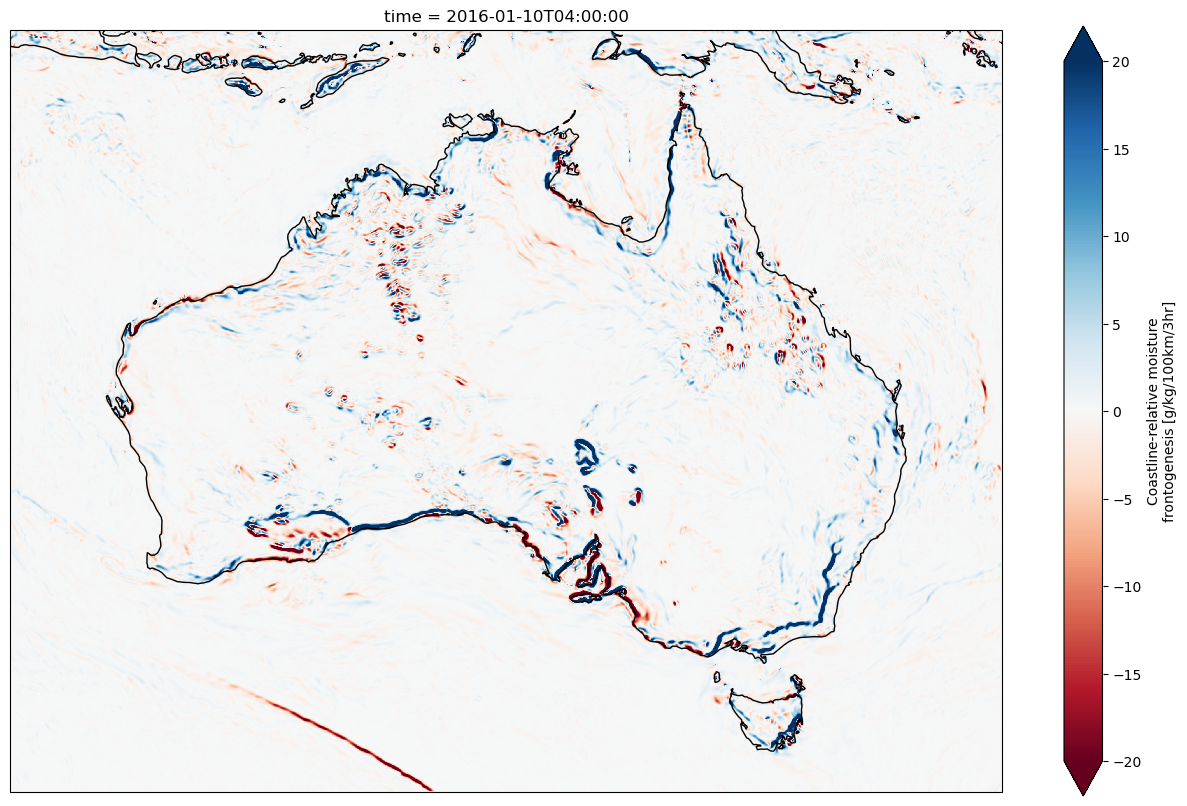

In [8]:
plt.figure(figsize=[16,10])
ax=plt.axes(projection=ccrs.PlateCarree())
Fc_smooth.plot(vmin=-20,vmax=20,cmap="RdBu")
ax.coastlines()

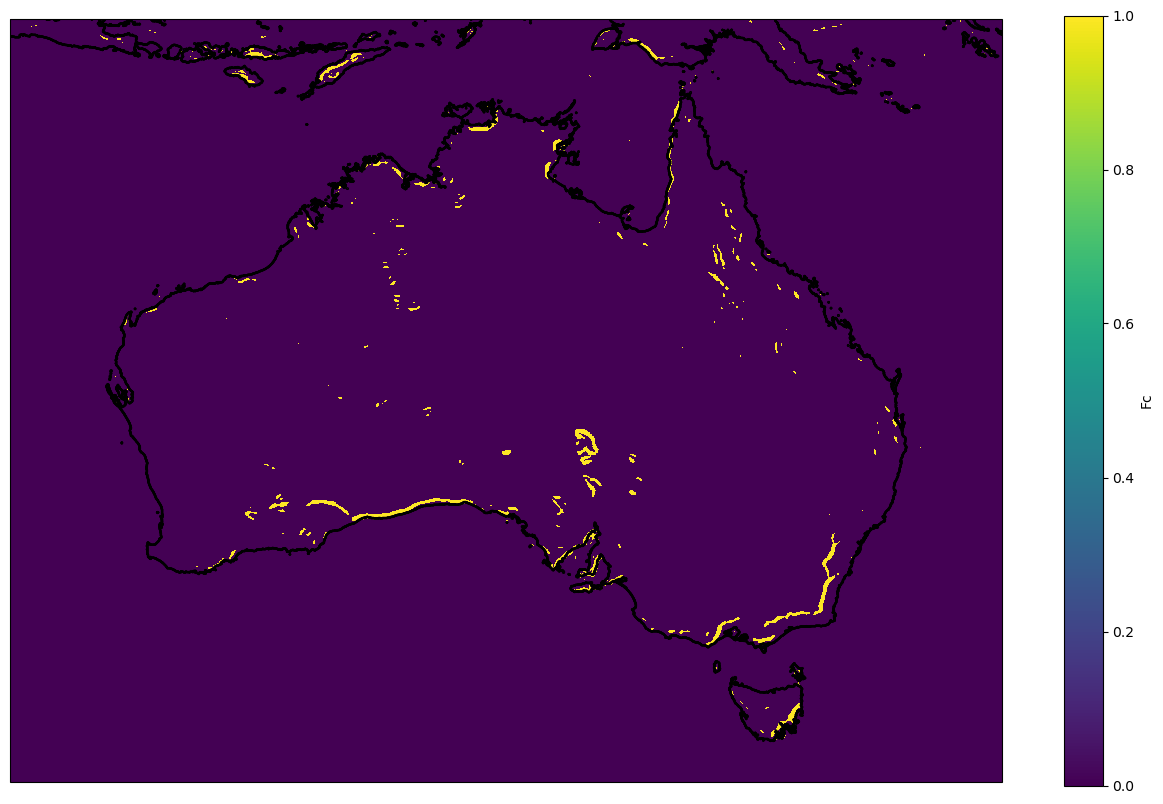

In [27]:
plt.figure(figsize=[16,10])

ax=plt.axes(projection=ccrs.PlateCarree())
(Fc_smooth > 15.1).plot()
xr.plot.contour(lsm,colors="k")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 51.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2025-03-13 10:37:23,629 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-03-13 10:37:24,047 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-03-13 10:37:24,512 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2025-03-13 10:37:25,050 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2025-03-13 10:37:25,664 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2025-03-13 10:37:26,400 - distributed.utils_perf - WARNING - full garbage collec

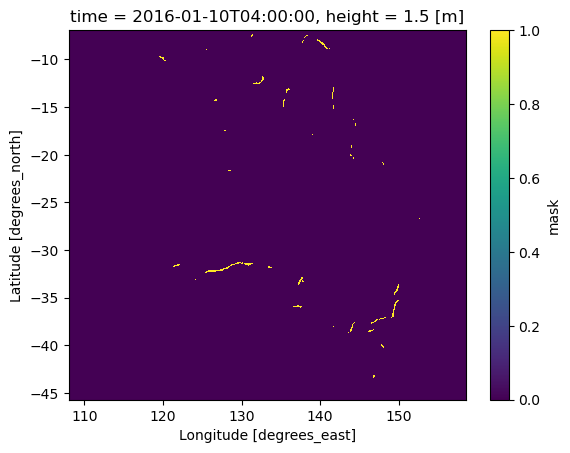

In [11]:
field = Fc_smooth

kwargs = {
    "orientation_filter":True,
    "aspect_filter":True,
    "area_filter":True,        
    "land_sea_temperature_filter":True,                    
    "temperature_change_filter":True,
    "humidity_change_filter":True,
    "wind_change_filter":True,
    "propagation_speed_filter":True,
    "dist_to_coast_filter":False,
    "output_land_sea_temperature_diff":False,        
    "time_filter":False,
    "orientation_tol":45,
    "area_thresh_pixels":12,
    "aspect_thresh":2,
    "land_sea_temperature_diff_thresh":0,
    "propagation_speed_thresh":0,
    }

ds = sea_breeze_filters.filter_3d(
    field,
    threshold="fixed",
    threshold_value=23.3,
    hourly_change_ds=hourly_change_ds,
    ta=aus2200_tas,
    vprime=vprime.drop_vars("height"),
    lsm=lsm,
    angle_ds=angle_ds,
    props_df_out_path="/scratch/ng72/ab4502/tmp/props_df",
    save_mask=False,
    **kwargs)

ds.mask.plot()

2025-02-12 10:47:13,677 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:14,523 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:15,383 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:16,394 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:17,423 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:18,651 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-02-12 10:47:19,942 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2025-02-12 10:49:16,046 - distributed.utils_perf - WARNING - full garbage collections took

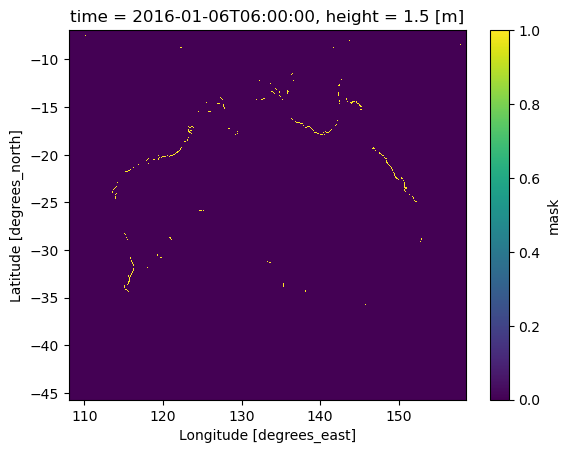

In [76]:
field = Fc_smooth

kwargs = {
    "orientation_filter":True,
    "aspect_filter":True,
    "area_filter":True,        
    "land_sea_temperature_filter":True,                    
    "temperature_change_filter":True,
    "humidity_change_filter":True,
    "wind_change_filter":True,
    "propagation_speed_filter":True,
    "dist_to_coast_filter":False,
    "output_land_sea_temperature_diff":False,        
    "time_filter":False,
    "orientation_tol":45,
    "area_thresh_pixels":12,
    "aspect_thresh":2,
    "land_sea_temperature_diff_thresh":0,
    "propagation_speed_thresh":0,
    }

ds = sea_breeze_filters.filter_3d(
    field,
    threshold="fixed",
    threshold_value=60,
    hourly_change_ds=hourly_change_ds,
    ta=aus2200_tas,
    vprime=vprime.drop_vars("height"),
    lsm=lsm,
    angle_ds=angle_ds,
    props_df_out_path="/scratch/ng72/ab4502/tmp/props_df",
    save_mask=False,
    **kwargs)

ds.mask.plot()

In [41]:
field = field.chunk({"time":1,"lat":-1,"lon":-1})

ds = sea_breeze_filters.binary_mask(field, 12.6)

ta=ta.chunk({"time":1,"lat":-1,"lon":-1})
ds = xr.merge((ds,ta.rename("ta")),join="exact")   
hourly_change_ds = hourly_change_ds.chunk({"time":1,"lat":-1,"lon":-1})
ds = xr.merge((ds,hourly_change_ds),join="exact").squeeze()

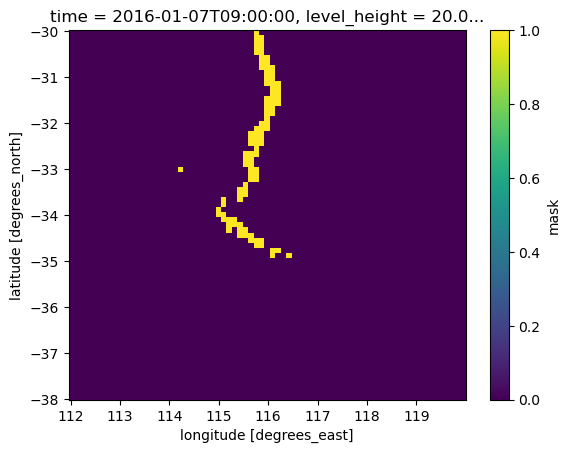

In [42]:
ds.mask.plot()

In [63]:
mask_options = sea_breeze_filters.Mask_Options().set_options(kwargs)

In [64]:
#Get time for data array
#time = pd.to_datetime(mask.time.values).strftime("%Y-%m-%d %H:%M")
time = ds.time.values

#From a binary (mask) array of candidate sea breeze objects, label from 1 to N
labels = skimage.measure.label(ds["mask"])
labels_da = xr.DataArray(labels, dims=ds["mask"].dims, coords=ds["mask"].coords)

#Using skimage, return properties for each candidate object
region_props = skimage.measure.regionprops(labels,spacing=(1,1))

#Get longitudes of image for the purpose of converting to local solar time
lons = ds.lon.values

#Get area of pixels using metpy
dx,dy,pixel_area = utils.metpy_grid_area(ds.lon,ds.lat)
pixel_area = xr.DataArray(pixel_area,coords=ds["mask"].coords,dims=ds["mask"].dims)

In [65]:
vprime.squeeze().groupby(labels_da.rename("label")).mean().to_series().drop(0)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


label
1   -4.791392
2   -3.238459
3   -2.826245
4   -3.134421
dtype: float64

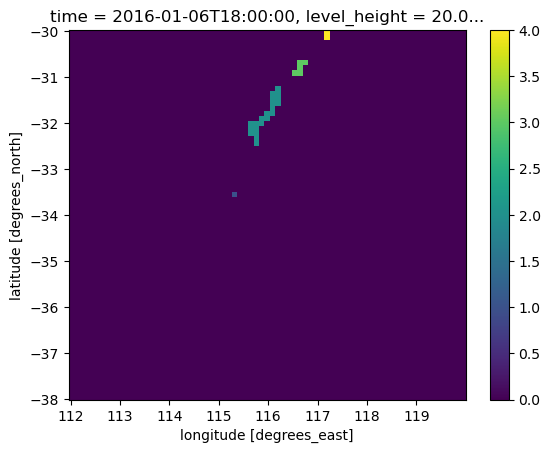

In [66]:
labels_da.plot()

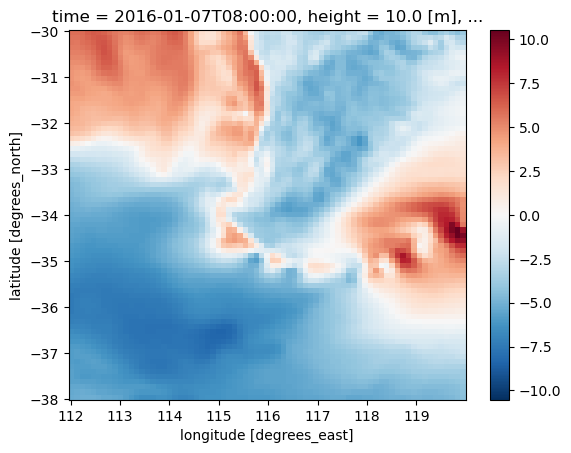

In [49]:
vprime.plot()

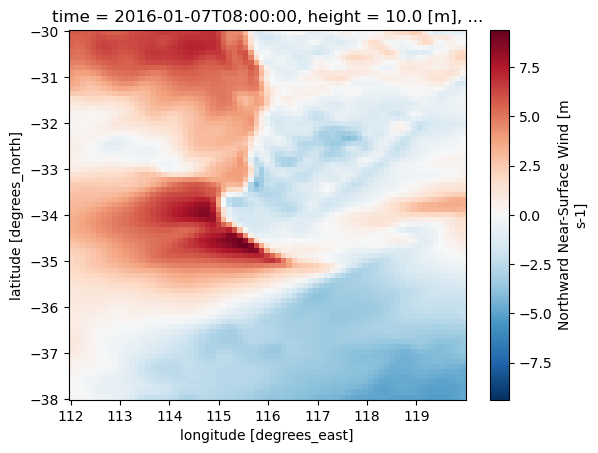

In [53]:
vas.plot()